# Machine learning applied to 0D reactors with multiple dt prediction: *dt* input method

In [1]:
use_colab = False

## Google colab preparation

These lines are here to enable Colab running of the tools. We need to perform a git clone in order to have access to python scripts. This needs to be done at each runtime as the clone is lost. 

In [2]:
import os

if use_colab:
    !git clone -b cost_course_exercices https://github.com/cmehl/ML_chem.git
    
    !pip install cantera

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Create a folder in the root directory
    if not os.path.isdir("/content/drive/MyDrive/ML_chem_data"):
        !mkdir -p "/content/drive/MyDrive/ML_chem_data"
    else:
        print("Folder /content/drive/MyDrive/ML_chem_data already exists")

## Imports and options

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
import time
import json
import joblib
import numpy as np
import pandas as pd

import cantera as ct

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme("notebook")

if use_colab:
    from ML_chem.chem_ai.cantera_runs import compute_nn_cantera_0D_homo
    from ML_chem.chem_ai.utils import get_molar_mass_atomic_matrix
    from ML_chem.chem_ai.utils import StandardScaler
else:
    from chem_ai.cantera_runs import compute_nn_cantera_0D_homo
    from chem_ai.utils import get_molar_mass_atomic_matrix
    from chem_ai.utils import StandardScaler

We set the default pytorch precision to double. It slows down a little bit the training but it is the usual standard for CFD reacting flows applications.

In [5]:
torch.set_default_dtype(torch.float64)

We identify the device (CPU or GPU) available on the machine. This will be used by pytorch to identify the device on which to train and use the model:

In [6]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


## Preliminary

We define the folder including the desired database:

In [7]:
if use_colab:
    folder = "/content/drive/MyDrive/ML_chem_data/case_0D_test_multidt"
else:
    folder = "./case_0D_test_multidt_baseline" 

We load the parameters stored in the json file of the dabatase folder:

In [8]:
with open(os.path.join(folder, "dtb_params.json"), "r") as file:
    dtb_params = json.load(file)

fuel = dtb_params["fuel"]
mech_file = dtb_params["mech_file"]
log_transform = dtb_params["log_transform"]
threshold = dtb_params["threshold"]
p = dtb_params["p"]
dt = dtb_params["dt"]

print(f"fuel={fuel}")
print(f"mech_file={mech_file}")
print(f"log_transform={log_transform}")
print(f"threshold={threshold}")
print(f"p={p}")
print(f"dt={dt}")

fuel=H2
mech_file=./data/mechanisms/mech_h2.yaml
log_transform=True
threshold=1e-10
p=101325.0
dt=1e-07


We load the scaler:

In [9]:
Xscaler = joblib.load(os.path.join(folder, "processed_database", "Xscaler.pkl"))

We load the training and validation databases:

In [10]:
X_train = np.load(os.path.join(folder, "processed_database", "X_train.npy"))
X_val = np.load(os.path.join(folder, "processed_database", "X_val.npy"))
Y_train = np.load(os.path.join(folder, "processed_database", "Y_train.npy"))
Y_val = np.load(os.path.join(folder, "processed_database", "Y_val.npy"))

dt_array_train = np.load(os.path.join(folder, "dt_array_train.npy"))
dt_array_val = np.load(os.path.join(folder, "dt_array_val.npy"))

Number of input and output dimensions, and number of dt values:

In [13]:
n_s_train = X_train.shape[0]
n_s_val = X_val.shape[0]

n_in = X_train.shape[1]
n_out = Y_train.shape[1]
nb_dt = Y_train.shape[2]


print(f"There are {n_s_train} train vectors")
print(f"There are {n_s_val} validation vectors")
print("")
print(f"Input dimension: {n_in}")
print(f"Output dimension: {n_out}")
print(f"Number of dt: {nb_dt}")

There are 340957 train vectors
There are 70550 validation vectors

Input dimension: 10
Output dimension: 9
Number of dt: 5


In [14]:
gas = ct.Solution(mech_file)
A_element = get_molar_mass_atomic_matrix(gas.species_names, fuel, True)
print(A_element)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         1.         0.         0.         0.05926971 0.11190674
  0.         0.0305399  0.05926971]
 [0.         0.         1.         1.         0.94073029 0.88809326
  0.         0.9694601  0.94073029]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.        ]]


In this first method, which we could qualify as brute force, we add *dt* as an input of the network. 

We first need to prepare datasets so that we have the list of input and corresponding outputs.

### Model training

First we tackle inputs.

As *dt* is used as an input of the NN, it is necessary here to scale it:

In [15]:
# It needs to be done on a flatted version of dt_array
dt_array_train_flat = dt_array_train.flatten()
dt_array_val_flat = dt_array_val.flatten()

Tscaler = StandardScaler()
Tscaler.fit(dt_array_train_flat)
dt_array_train_flat_s = Tscaler.transform(dt_array_train_flat)
dt_array_val_flat_s = Tscaler.transform(dt_array_val_flat)

In [16]:
# TRAINING
X_train_1 = np.empty((nb_dt*n_s_train,n_in+1))

for i_dt in range(nb_dt):
    X_train_1[i_dt::nb_dt,:-1] = X_train

X_train_1[:,-1] = dt_array_train_flat_s


# VALIDATION
X_val_1 = np.empty((nb_dt*n_s_val,n_in+1))

for i_dt in range(nb_dt):
    X_val_1[i_dt::nb_dt,:-1] = X_val

X_val_1[:,-1] = dt_array_val_flat_s


Then we focus on outputs:

In [17]:
# TRAINING
Y_train_1 = np.empty((nb_dt*n_s_train,n_out))

for i_dt in range(nb_dt):
    Y_train_1[i_dt::nb_dt,:] = Y_train[:,:,i_dt]


# VALIDATION
Y_val_1 = np.empty((nb_dt*n_s_val,n_out))

for i_dt in range(nb_dt):
    Y_val_1[i_dt::nb_dt,:] = Y_val[:,:,i_dt]

In [18]:
X_train_1 = torch.tensor(X_train_1, dtype=torch.float64)
Y_train_1 = torch.tensor(Y_train_1, dtype=torch.float64)
X_val_1 = torch.tensor(X_val_1, dtype=torch.float64)
Y_val_1 = torch.tensor(Y_val_1, dtype=torch.float64)

In [19]:
Xscaler_mean = torch.from_numpy(Xscaler.mean)
Xscaler_std = torch.from_numpy(Xscaler.std)

In [20]:
A_element = torch.tensor(A_element, dtype=torch.float64)

In [21]:
X_train_1 = X_train_1.to(device)
Y_train_1 = Y_train_1.to(device)
X_val_1 = X_val_1.to(device)
Y_val_1 = Y_val_1.to(device)

Xscaler_mean = Xscaler_mean.to(device)
Xscaler_std = Xscaler_std.to(device)

A_element = A_element.to(device)

We now can generate the model. In this work, we will consider a simple Multi Layer Perceptron (MLP). We generate the model using Pytorch:

In [22]:
class ChemNN_multi(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(n_in + 1, 100)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(100, 100)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(100, n_out)
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x

The model is then instantiated and transferred to the GPU if present:

In [23]:
model = ChemNN_multi()
print(model)

# Put model on GPU
model = model.to(device)

ChemNN_multi(
  (hidden1): Linear(in_features=11, out_features=100, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=100, out_features=9, bias=True)
)


In [24]:
n_epochs = 300
batch_size = 256

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
def main_training_loop(X_train, X_val, Y_train, Y_val, loss_fn, optimizer, n_epochs, model, log_transform):

    # Array to store the loss and validation loss
    loss_list = np.empty(n_epochs)
    val_loss_list = np.empty(n_epochs//10)

    # Array to store sum of mass fractions: mean, min and max
    stats_sum_yk = np.empty((n_epochs//10,3))

    # Array to store elements conservation: mean, min and max
    stats_A_elements = np.empty((n_epochs//10,4,3))

    epochs = np.arange(n_epochs)
    epochs_small = epochs[::10]

    for epoch in range(n_epochs):

        # Training parameters
        for i in range(0, len(X_train), batch_size):

            Xbatch = X_train[i:i+batch_size]
            y_pred = model(Xbatch)
            ybatch = Y_train[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list[epoch] = loss

        # Computing validation loss and mass conservation metric (only every 10 epochs as it is expensive)
        if epoch%10==0:
            model.eval()  # evaluation mode
            with torch.no_grad():

                # VALIDATION LOSS
                y_val_pred = model(X_val)
                val_loss = loss_fn(y_val_pred, Y_val)

                # SUM OF MASS FRACTION
                #Inverse scale done by hand to stay with Torch arrays
                yk = Xscaler_mean[1:] + (Xscaler_std[1:] + 1e-7)*y_val_pred
                if log_transform:
                    yk = torch.exp(yk)
                sum_yk = yk.sum(axis=1)
                sum_yk = sum_yk.detach().cpu().numpy()
                stats_sum_yk[epoch//10,0] = sum_yk.mean() 
                stats_sum_yk[epoch//10,1] = sum_yk.min()
                stats_sum_yk[epoch//10,2] = sum_yk.max()

                # ELEMENTS CONSERVATION
                yval_in = Xscaler_mean[1:] + (Xscaler_std[1:] + 1e-7)*X_val[:,1:-1]
                if log_transform:
                    yval_in = torch.exp(yval_in)
                ye_in = torch.matmul(A_element, torch.transpose(yval_in, 0, 1))
                ye_out = torch.matmul(A_element, torch.transpose(yk, 0, 1))
                delta_ye = (ye_out - ye_in)/(ye_in+1e-10)
                delta_ye = delta_ye.detach().cpu().numpy()
                stats_A_elements[epoch//10, :, 0] = delta_ye.mean(axis=1)
                stats_A_elements[epoch//10, :, 1] = delta_ye.min(axis=1)
                stats_A_elements[epoch//10, :, 2] = delta_ye.max(axis=1)

            model.train()   # Back to training mode
            val_loss_list[epoch//10] = val_loss

        print(f"Finished epoch {epoch}")
        print(f"    >> Loss: {loss}")
        if epoch%10==0:
            print(f"    >> Validation loss: {val_loss}")

    return epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements

In [26]:
start_time = time.perf_counter()
epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements = main_training_loop(X_train_1, X_val_1, Y_train_1, Y_val_1, loss_fn, optimizer, n_epochs, model, log_transform)
end_time = time.perf_counter()
print(f" TRAINING DURATION: {end_time-start_time} s")

Finished epoch 0
    >> Loss: 0.00033547994668734334
    >> Validation loss: 0.0008455657994291826
Finished epoch 1
    >> Loss: 0.00021879855503920763
Finished epoch 2
    >> Loss: 0.00026539706477626525
Finished epoch 3
    >> Loss: 0.0003292001824703371
Finished epoch 4
    >> Loss: 0.0002580803893869829
Finished epoch 5
    >> Loss: 0.0001860273616053176
Finished epoch 6
    >> Loss: 0.00017851853156990286
Finished epoch 7
    >> Loss: 0.00022877330675121458
Finished epoch 8
    >> Loss: 0.00020619442088039042
Finished epoch 9
    >> Loss: 0.00018440146676834766
Finished epoch 10
    >> Loss: 0.00017378495777561
    >> Validation loss: 0.00016927364233628803
Finished epoch 11
    >> Loss: 0.00020111261317296543
Finished epoch 12
    >> Loss: 0.00013665861743191238
Finished epoch 13
    >> Loss: 0.0001965597999271051
Finished epoch 14
    >> Loss: 0.00017573666361389527
Finished epoch 15
    >> Loss: 0.0001025175037344091
Finished epoch 16
    >> Loss: 0.00012992085102964872
Finishe

We can define a function to analyze the training. We plot:

+ The training and validation losses

+ The evolution of $\sum_{k=1}^{N_S} Y_k$ (mean, min and max).

+ The elements conservation by plotting $100\times\delta Y_e$ for each element (C, H, O and N). The factor $100$ enables to get an error in \%.

In [27]:
def plot_losses_conservation(epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements):

    # LOSSES
    fig, ax = plt.subplots()

    ax.plot(epochs, loss_list, color="k", label="Training")
    ax.plot(epochs_small, val_loss_list, color="r", label = "Validation")

    ax.set_yscale('log')

    ax.legend()

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")

    # MASS CONSERVATION
    fig, ax = plt.subplots()

    ax.plot(epochs_small, stats_sum_yk[:,0], color="k")
    ax.plot(epochs_small, stats_sum_yk[:,1], color="k", ls="--")
    ax.plot(epochs_small, stats_sum_yk[:,2], color="k", ls="--")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(r"$\sum_k \ Y_k$")

    # ELEMENTS CONSERVATION
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

    # C
    ax1.plot(epochs_small, 100*stats_A_elements[:,0,0], color="k")
    ax1.plot(epochs_small, 100*stats_A_elements[:,0,1], color="k", ls="--")
    ax1.plot(epochs_small, 100*stats_A_elements[:,0,2], color="k", ls="--")

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel(r"$\Delta Y_C$ $(\%$)")

    # H
    ax2.plot(epochs_small, 100*stats_A_elements[:,1,0], color="k")
    ax2.plot(epochs_small, 100*stats_A_elements[:,1,1], color="k", ls="--")
    ax2.plot(epochs_small, 100*stats_A_elements[:,1,2], color="k", ls="--")

    ax2.set_xlabel("Epoch")
    ax2.set_ylabel(r"$\Delta Y_H$ $(\%)$")

    # O
    ax3.plot(epochs_small, 100*stats_A_elements[:,2,0], color="k")
    ax3.plot(epochs_small, 100*stats_A_elements[:,2,1], color="k", ls="--")
    ax3.plot(epochs_small, 100*stats_A_elements[:,2,2], color="k", ls="--")

    ax3.set_xlabel("Epoch")
    ax3.set_ylabel(r"$\Delta Y_O$ $(\%)$")

    # N
    ax4.plot(epochs_small, 100*stats_A_elements[:,3,0], color="k")
    ax4.plot(epochs_small, 100*stats_A_elements[:,3,1], color="k", ls="--")
    ax4.plot(epochs_small, 100*stats_A_elements[:,3,2], color="k", ls="--")

    ax4.set_xlabel("Epoch")
    ax4.set_ylabel(r"$\Delta Y_N$ $(\%)$")

    fig.tight_layout()

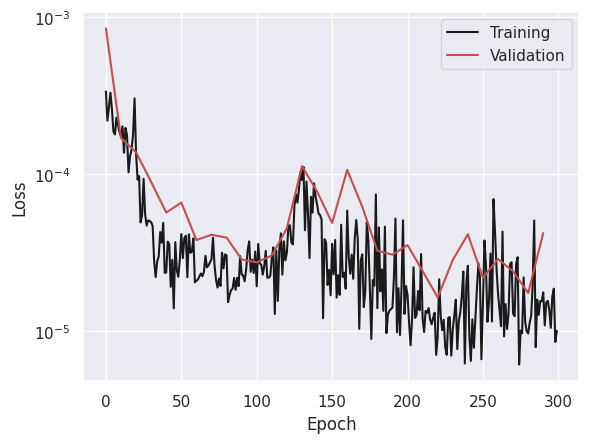

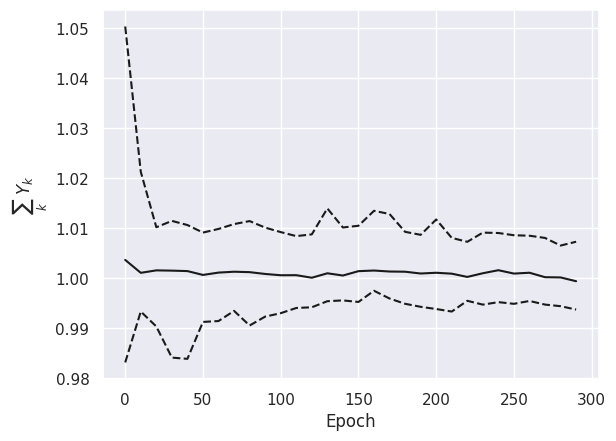

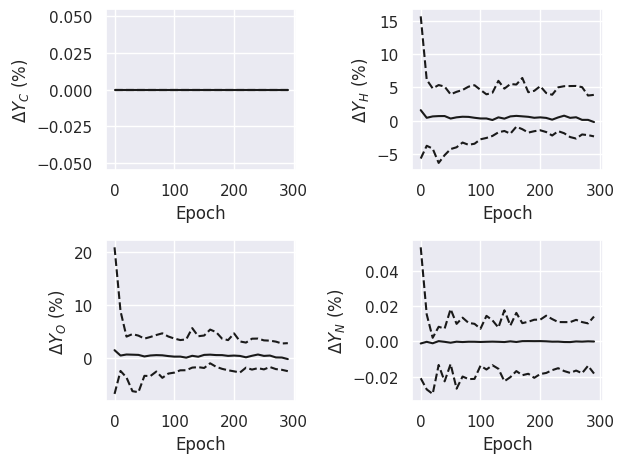

In [28]:
plot_losses_conservation(epochs, epochs_small, loss_list, val_loss_list, stats_sum_yk, stats_A_elements)

We save the Pytorch model in the case folder for later use:

In [29]:
torch.save(model.state_dict(), os.path.join(folder,"pytorch_mlp.pt"))

### Model testing

We first load the test initial conditions:

In [30]:
df_sim_test = pd.read_csv(os.path.join(folder, "sim_test.csv"))

n_sim = df_sim_test.shape[0]
print(f"There are {n_sim} test simulations")

There are 64 test simulations


In [31]:
def run_test_simulations(dt):

    list_test_results = []

    fails = 0
    for i, row in df_sim_test.iterrows():

        phi_ini = row['Phi']
        temperature_ini = row['T0']

        print(f"Performing test computation for phi={phi_ini}; T0={temperature_ini}")

        df_exact, df_nn, fail = compute_nn_cantera_0D_homo(device, model, Xscaler, Xscaler, phi_ini, temperature_ini, dt, dtb_params, A_element.detach().cpu().numpy(), True, Tscaler)

        fails += fail

        list_test_results.append((df_exact, df_nn))


    print(f"dt={dt}:Total number of simulations which crashed: {fails}")

    return list_test_results

In [32]:
dt_list = [0.1e-6, 0.2e-6, 0.4e-6, 0.6e-6, 0.8e-6, 1e-6, 1.2e-6, 1.4e-6, 1.6e-6, 1.8e-6, 2.0e-6]
dict_test_res = {}

for dt in dt_list:

     print(f"RUNNING SIMULATIONS FOR DT={dt}")
     dict_test_res[dt] = run_test_simulations(dt)

RUNNING SIMULATIONS FOR DT=1e-07
Performing test computation for phi=0.9018401193381748; T0=1733.496481885861
Performing test computation for phi=0.8820224064799937; T0=1736.5502745975996
Performing test computation for phi=0.8587049360576307; T0=1797.7801647532792
Performing test computation for phi=0.8742439774442669; T0=1758.0051625473495
Performing test computation for phi=0.8637073853854452; T0=1769.5860460371498
Performing test computation for phi=0.9648684728242076; T0=1795.6268751475354
Performing test computation for phi=0.926974526483462; T0=1728.3899711684594
Performing test computation for phi=0.9148044461029808; T0=1757.982010042148
Performing test computation for phi=0.9747599866367844; T0=1791.5323023213864
Performing test computation for phi=0.8166587174434471; T0=1781.544823668742
Performing test computation for phi=0.9554920824557817; T0=1706.4614534373177
Performing test computation for phi=0.9244182127965022; T0=1710.6464206747328
Performing test computation for phi

We write a function to plot a given simulation, for a given dt: (in *dt_list*)

In [33]:
def plot_results_sim(i_sim, dt, dict_test_res, spec_to_plot):

    df_exact =  dict_test_res[dt][i_sim][0]
    df_nn =  dict_test_res[dt][i_sim][1]

    # Temperature 
    fig, ax = plt.subplots()

    ax.plot(df_exact['Time'], df_exact['Temperature'], color='k')
    ax.plot(df_nn['Time'], df_nn['Temperature'], color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("T [K]")

    # Species (normal)
    fig, ax = plt.subplots()

    ax.plot(df_exact['Time'], df_exact[spec_to_plot], color='k')
    ax.plot(df_nn['Time'], df_nn[spec_to_plot], color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel(f"{spec_to_plot} [-]")

    # Species (log)
    fig, ax = plt.subplots()

    ax.plot(df_exact['Time'], np.log(df_exact[spec_to_plot]), color='k')
    ax.plot(df_nn['Time'], np.log(df_nn[spec_to_plot]), color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel(f"{spec_to_plot} [-]")

    # Sum of Yk
    fig, ax = plt.subplots()
    ax.plot(df_nn['Time'], df_nn['SumYk'], color='b')
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("$\sum Y_k$ [-]")

    # Elements
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
    ax1.plot(df_nn['Time'], df_nn['Y_C'], color='b')
    ax2.plot(df_nn['Time'], df_nn['Y_H'], color='b')
    ax3.plot(df_nn['Time'], df_nn['Y_O'], color='b')
    ax4.plot(df_nn['Time'], df_nn['Y_N'], color='b')
    ax1.set_ylabel("$Y_C$")
    ax2.set_ylabel("$Y_H$")
    ax3.set_ylabel("$Y_O$")
    ax4.set_ylabel("$Y_N$")
    ax3.set_xlabel("Time [s]")
    ax4.set_xlabel("Time [s]")
    fig.tight_layout()

/work/mehlc/Python_env/venv_pytorch/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


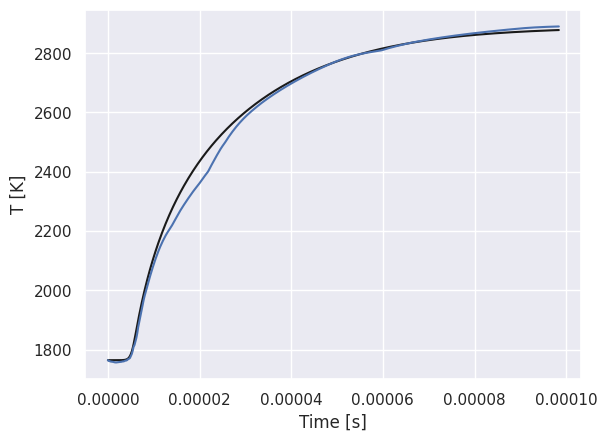

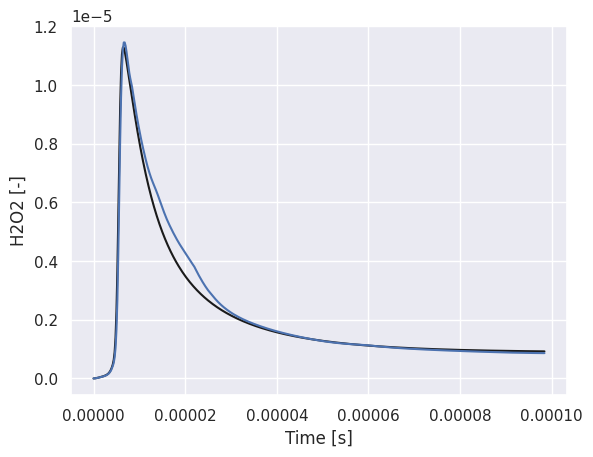

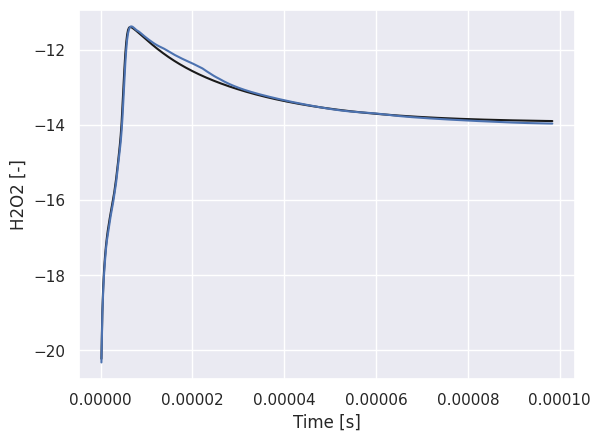

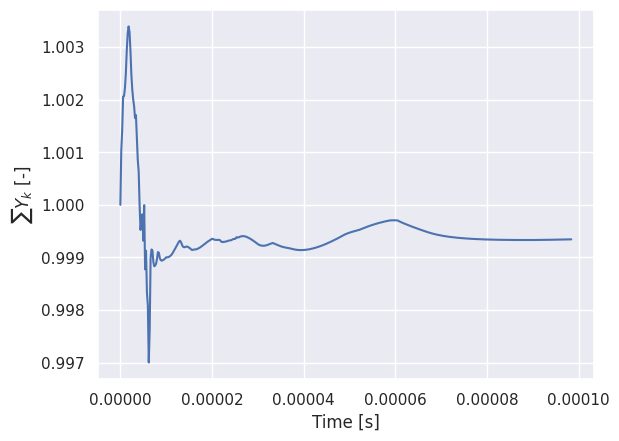

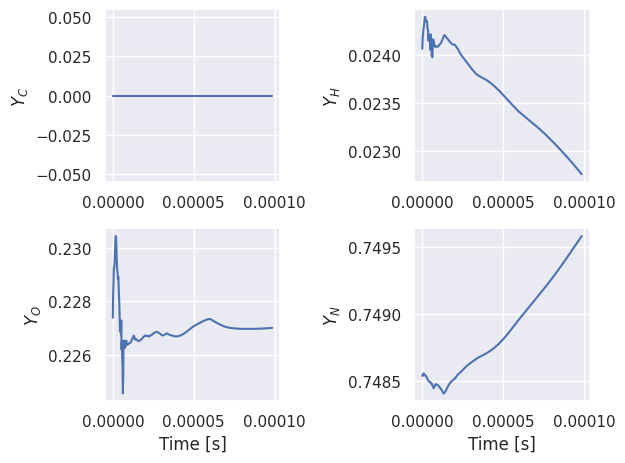

In [41]:
dt = 2e-7
i_sim = 20
spec_to_plot = "H2O2"
plot_results_sim(i_sim, dt, dict_test_res, spec_to_plot)

Function to compute fitness between two simulations:

In [35]:
def compute_fitness(list_test_results):

    # Results will be stored in data_errors array.
    # The first column corresponds to errors on temperature
    # The next n_out columns correspond to errors on species mass fractions
    # The last column corresponds to the mean error
    data_errors = np.empty([n_sim, n_out+2]) 

    for i_sim in range(n_sim):

        df_exact = list_test_results[i_sim][0]
        df_nn = list_test_results[i_sim][1]

        # Removing undesired variables
        df_exact = df_exact.drop('Time', axis=1)
        df_nn = df_nn.drop(["Time","SumYk", "Y_C", "Y_H", "Y_O", "Y_N"], axis=1)

        # Applying log
        if log_transform:

            df_exact[df_exact < threshold] = threshold
            df_nn[df_nn < threshold] = threshold

            df_exact.iloc[:, 1:] = np.log(df_exact.iloc[:, 1:])
            df_nn.iloc[:, 1:] = np.log(df_nn.iloc[:, 1:])

        # Scaling
        data_exact_scaled = (df_exact-Xscaler.mean)/(Xscaler.std+1.0e-7)
        data_nn_scaled = (df_nn-Xscaler.mean)/(Xscaler.std+1.0e-7)

        diff_exact_nn = np.abs((data_nn_scaled-data_exact_scaled)/data_exact_scaled)

        diff_exact_nn = diff_exact_nn.mean(axis=0)

        M = diff_exact_nn.mean()

        print(f"Simulation {i_sim} error M = {M}")

        data_errors[i_sim, :n_out+1] = diff_exact_nn
        data_errors[i_sim, n_out+1] = M


    return data_errors

In [36]:
data_errors = {}
for dt in dt_list:
    data_errors[dt] = compute_fitness(dict_test_res[dt])

Simulation 0 error M = 2.4037352062216852
Simulation 1 error M = 1109.636617188689
Simulation 2 error M = 2.40794000425904
Simulation 3 error M = 7.976786792171998
Simulation 4 error M = 6.506551928945925
Simulation 5 error M = 6.442081999602441
Simulation 6 error M = 9.874500637399553
Simulation 7 error M = 1.637668682969677
Simulation 8 error M = 3.099647467314786
Simulation 9 error M = 3.1136006868769988
Simulation 10 error M = 5.561935281189693
Simulation 11 error M = 2.4369834027419723
Simulation 12 error M = 6.747271268190644
Simulation 13 error M = 1.9035733014836231
Simulation 14 error M = 10.375448485285379
Simulation 15 error M = 2.08495453582617
Simulation 16 error M = 1597.069667246382
Simulation 17 error M = 7.808084138794584
Simulation 18 error M = 1.5563252811117927
Simulation 19 error M = 3.223038187979772
Simulation 20 error M = 10.464363347505003
Simulation 21 error M = 4.555470421770038
Simulation 22 error M = 13.059942866799748
Simulation 23 error M = 78.13563203339

We compute the mean and std error for each dt:

In [37]:
data_errors_mean = np.empty(len(dt_list))
data_errors_std = np.empty(len(dt_list))

for i, dt in enumerate(dt_list):
    data_errors_mean[i] = data_errors[dt][:,-1].mean()
    data_errors_std[i] = data_errors[dt][:,-1].std()

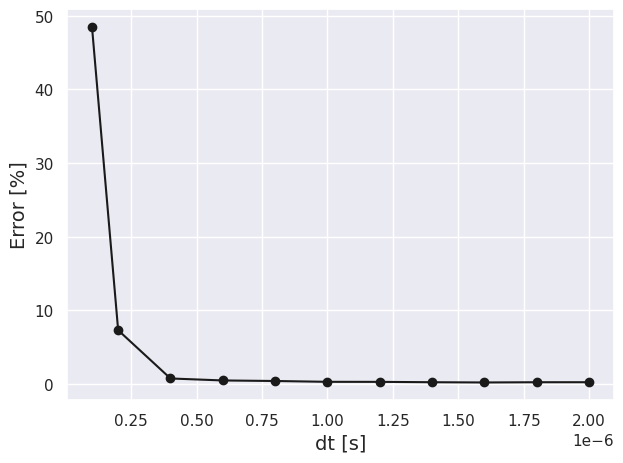

In [38]:
fig, ax = plt.subplots()

ax.plot(dt_list, data_errors_mean, color="k", marker="o")

ax.set_xlabel("dt [s]", fontsize=14)
ax.set_ylabel("Error [%]", fontsize=14)

fig.tight_layout()